<a href="https://www.kaggle.com/code/esaulgonzalez/bootstrap?scriptVersionId=105532372" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

library(moments)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



character(0)

# Ejercicio 1

Lo primero es importar los datos con los que vamos a trabajar, en este caso, sólo copié y pegué

In [2]:
# Datos del ejercicio
LSAT <- c(576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594)
GPA <- c(3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 3.96)

## Definición de funciones

Esta es la parte más larga y que va a servir también para los siguientes ejercicios. Voy a definir funciones que hagan lo que necesito para después poder llamarlas.

In [3]:
# Primero la media como una función dummy para evaluar que todo funciona
media <- function(vec){
    return( sum(vec) / length(vec) )
}

# Definir el estimador plug-in para el coeficiente de correlación
corr <- function(vec1,vec2){
    theta <- ( sum((vec1 - media(vec1))*(vec2 - media(vec2)) ) ) / ( sqrt( sum( (vec1-media(vec1))**2)*(sum( (vec2 - media(vec2))**2 ))   ) )
    return(theta)
}

# Evaluamos el coeficiente de correlación
hat_theta <- corr(LSAT,GPA)

In [4]:
# Definir la función de bootstrap para estimadores que toma un sólo argumento
bootstrap <- function(vec, func, size){
    # Inicializamos un vector de tamaño especificado al llamar la función
    estimates <- c(1:size)
    # Mediante un ciclo generamos muestras aleatorias de nuestra muestra original y evaluamos el estimador en ese punto
    for (i in 1:size){
        x <- sample(vec, size=length(vec), replace=TRUE) # Muestra con reemplazo
        estimates[i] <- func(x) # Evaluar la función
    }
    return(estimates) # Regresar como salida la lista de los valores estimados
}

In [5]:
# Esta función es similar, pero hace bootstrap para funciones con dos argumentos
dual_bootstrap <- function(val1, val2, func, size){
    estimates <- c(1:size)
    # Al igual que en el otro caso, creamos muestras aleatorias
    for (i in 1:size){
        index <- sample( (1:length(val1)), size=length(val1), replace=TRUE)
        x <- rep(0, times=length(val1))
        y <- rep(0, times=length(val1))
        # En este caso, es muy importante que tomemos el mismo índice en ambos arreglos
        for (j in 1:length(index)){
            x[j] <- val1[index[j]]
            y[j] <- val2[index[j]]
        }
        estimates[i] <- func(x,y)
    }
    return(estimates)
}

In [6]:
# Función que crea un intervalo normal usando error estándar evaluado por bootstrap
nb_interval <- function(data, func, size, alpha){
    bdata <- bootstrap(data,func,size)
    se <- sd(bdata)
    theta <- func(data)
    z <- qnorm(1 - alpha/2)
    li <- theta - z*se
    ls <- theta + z*se
    return(c(li,ls))
}

In [7]:
# Esta función hace lo mismo que la anterior, pero con funciones de dos argumentos
dual_nb_interval <- function(data1, data2,func,size,alpha){
    dbdata <- dual_bootstrap(data1,data2,func,size)
    se <- sd(dbdata)
    theta <- func(data1,data2)
    z <- qnorm(1 - alpha/2)
    li <- theta - z*se
    ls <- theta + z*se
    return(c(li,ls))
}

In [8]:
# Función de distribución empírica usando bootstrap
bemp_Hr <- function(data,func,size){
    vec <- bootstrap(data,func,size)
    vec_R <- c(1:size)
    for(i in 1:size){
        vec_R[i] <- vec[i] - func(data)
    }
    empH <- seq(from=min(vec_R), to=max(vec_R), length.out=100) #c(min(vec_R):max(vec_R))
    for(j in 1:length(empH)){
        count <- 0
        for(k in vec_R){
            if(k <= empH[j]){
                count <- count + 1
            }
        }
        empH[j] <- (count / length(vec_R))
    }
    
    values <- seq(from=min(vec_R), to=max(vec_R), length.out=100) #min(vec_R):max(vec_R)
    return(list("values"=values, "CDF"=empH))
}

In [9]:
# Esto es para probar la función de distribución empírica
puntos <- bemp_Hr(LSAT,media,1000)

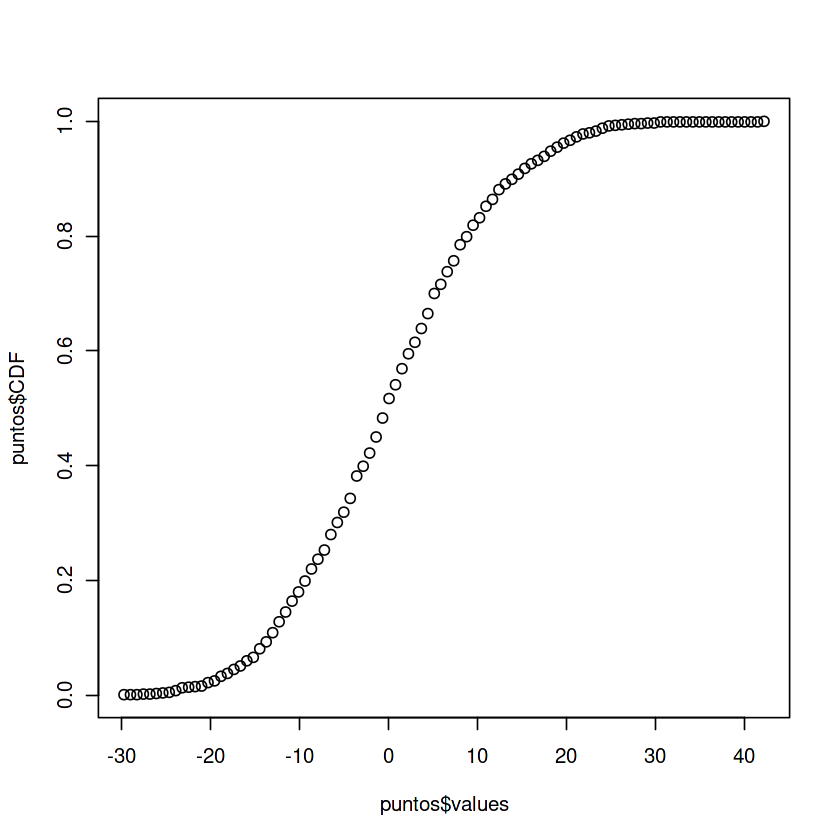

In [10]:
# Una gráfica nos muestra la distribución de los datos simulados con bootstrap
plot(puntos$"values",puntos$"CDF" )

In [11]:
# Inversa generalizada (inversa de la función de distribución empírica)
empH_inv <- function(data,func,size, x){
    punto <- bemp_Hr(data,func,size)
    candidate <- max(punto$"values")
    for (i in 1:length(punto$"CDF")){
        if ( (punto$"CDF"[i] >= x)){
            candidate <- min(candidate,punto$"values"[i])
        }
    }
    return(candidate)
}

In [12]:
# Probamos la inversa de la función de distribución empírica
empH_inv(LSAT,media,1000,0.5)

[1] 0.2909091

In [13]:
# Función de distribución empírica para funciones con dos argumentos
dual_bemp_Hr <- function(data1,data2,func,size){
    vec <- dual_bootstrap(data1,data2,func,size)
    vec_R <- c(1:size)
    for(i in 1:size){
        vec_R[i] <- vec[i] - func(data1,data2)
    }
    empH <-  seq(from=min(vec_R), to=max(vec_R), length.out=100 )  #c(min(vec_R):max(vec_R))
    for(j in 1:length(empH)){
        count <- 0
        for(k in vec_R){
            if(k <= empH[j]){
                count <- count + 1
            }
        }
        empH[j] <- (count / length(vec_R))
    }
    
    values <- seq(from=min(vec_R), to=max(vec_R), length.out=100 )
    return(list("values"=values, "CDF"=empH))
}

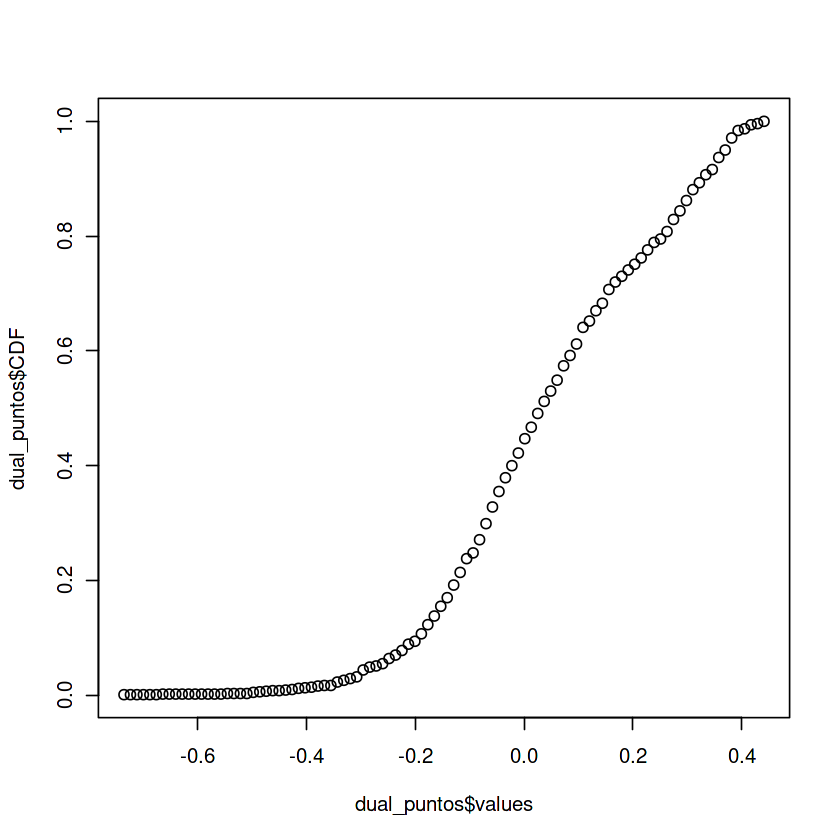

In [14]:
# Probar esta función de distribución empírica para los valores del ejercicio
dual_puntos <- dual_bemp_Hr(LSAT,GPA,corr,1000)
plot(dual_puntos$"values",dual_puntos$"CDF")

In [15]:
# Inversa de la función de distribución para funciones con dos argumentos
dual_empH_inv <- function(data1,data2,func,size, x){
    punto <- dual_bemp_Hr(data1,data2,func,size)
    candidate <- max(punto$"values")
    for (i in 1:length(punto$"CDF")){
        if ( (punto$"CDF"[i] >= x)){
            candidate <- min(candidate,punto$"values"[i])
        }
    }
    return(candidate)
}

In [16]:
# Intervalo pivotal bootstrap usando la inversa de función de distribución empírica creada
bpiv_interval <- function(data,func,size,alpha){
    hat <- func(data)
    Li <- hat - empH_inv(data,func,size, 1 - alpha/2)
    Ls <- hat - empH_inv(data,func,size,  alpha/2)
    return( c(Li,Ls) )
}

In [17]:
# Intervalo pivotal para funciones de dos valores
dual_bpiv_interval <- function(data1,data2,func,size,alpha){
    hat <- func(data1,data2)
    Li <- hat - dual_empH_inv(data1,data2,func,size, 1 - alpha/2)
    Ls <- hat - dual_empH_inv(data1,data2,func,size,  alpha/2)
    return( c(Li,Ls) )
}

In [18]:
# Probar el intervalo pivotal
dual_bpiv_interval(LSAT,GPA,corr,1000,0.05)

[1] 0.1408276 0.8927545

In [19]:
# Definición alternativa del intervalo pivotal usando la función quantile construida en R
alt_dbpiv_interval <- function(data1,data2,func,size,alpha){
    Tboot <- dual_bootstrap(data1,data2,func,size)
    pivotal <- c( 2*func(data1,data2) - quantile(Tboot,1-(alpha/2)), 2*func(data1,data2) - quantile(Tboot,alpha/2))
    return(pivotal)
}

In [20]:
# Definición alternativa del intervalo pivotal dual usando la función quantile construida en R
alt_bpiv_interval <- function(data,func,size,alpha){
    Tboot <- bootstrap(data,func,size)
    pivotal <- c( 2*func(data) - quantile(Tboot,1-(alpha/2)), 2*func(data) - quantile(Tboot,alpha/2))
    return(pivotal)
}

In [21]:
# Definición de una función para crear intervalos 
percentile_interval <- function(data,func,size,alpha){
    Tboot <- bootstrap(data,func,size)
    percentile <- c(quantile(Tboot,alpha/2),quantile(Tboot,1 - alpha/2))
    return(percentile)
}

In [22]:
# Definición de una función para crear intervalos 
dual_percentile_interval <- function(data1,data2,func,size,alpha){
    Tboot <- dual_bootstrap(data1,data2,func,size)
    percentile <- c(quantile(Tboot,alpha/2),quantile(Tboot,1-alpha/2))
    return(percentile)
}

### Una vez que tenemos todas las funciones necesarias, podemos evaluar los intervalos solicitados

In [23]:
normal_corr <- dual_nb_interval(LSAT,GPA,corr,1000,0.05)
pivotal_corr <- alt_dbpiv_interval(LSAT,GPA,corr,1000,0.05)
percentile_corr <- dual_percentile_interval(LSAT,GPA,corr,1000,0.05)

print(normal_corr)
print(pivotal_corr) 
print(percentile_corr)

[1] 0.1615386 0.9302993
    97.5%      2.5% 
0.1460337 0.8728923 
     2.5%     97.5% 
0.1752154 0.9342119 


# Ejercicio 2
En este caso ya tenemos las funciones creadas y sólo evaluamos lo que se pide

In [24]:
skew <- function(vec){
    skew <- (sum(( vec - mean(vec) )^3 ) / length(vec) )/( sd(vec) )^3
}

In [25]:
# Se crean las muestras de las v.a. como se especifica en el libro
Y <- rnorm(n=50)
X <- exp(Y)

print(skew(X))

[1] 1.706406


In [26]:
# Las veces que se va a repetir el experimento
muchas = 150

# Para poder promediar, evaluamos el límite inferior y superior de cada intervalo por separado
normal_skew_li <- c(1:muchas)
normal_skew_ls <- c(1:muchas)
pivotal_skew_li <- c(1:muchas)
pivotal_skew_ls <- c(1:muchas)
percentil_skew_li <- c(1:muchas)
percentil_skew_ls <- c(1:muchas)
for(n in 1:muchas){
    normal_par <- nb_interval(X,skew,1000,0.05)
    normal_skew_li[n] <- normal_par[1]
    normal_skew_ls[n] <- normal_par[2]
    pivot_par <- alt_bpiv_interval(X,skew,1000,0.05)
    pivotal_skew_li[n] <- pivot_par[1]
    pivotal_skew_ls[n] <- pivot_par[2]
    percen_par <- percentile_interval(X,skew,1000,0.05)
    percentil_skew_li[n] <- percen_par[1]
    percentil_skew_ls[n] <- percen_par[2]
}

# Guardamos todos los valores en un Data Frame
df <- data.frame(normal_skew_li,normal_skew_ls,pivotal_skew_li,pivotal_skew_ls,percentil_skew_li,percentil_skew_ls)

In [27]:
# Encontramos el valor teórico de la skewness para la lognormal de varianza 1

teo_skew <- (exp(1) + 2)*sqrt( exp(1) -1 )
print(teo_skew)

[1] 6.184877


In [28]:
# Esta función cuenta el porcentaje de intervalos que atrapan a un determinado valor
contar_cov <- function(val,li,ls){
    count <- 0
    for(i in 1:length(li)){
        if( (li[i] <= val) & (val <= ls[i])){
            count <- count + 1
        }
    }
    count <- (count / length(ls))
    return(count)
}

Con la función de conteo, estimamos la cobertura de los intervalos

In [29]:
cob_normal <- contar_cov(teo_skew,normal_skew_li,normal_skew_ls)
cob_pivotal <- contar_cov(teo_skew,pivotal_skew_li,pivotal_skew_ls)
cob_percentil <- contar_cov(teo_skew,percentil_skew_li,percentil_skew_ls)

print(cob_normal)
print(cob_pivotal)
print(cob_percentil)

[1] 0
[1] 0
[1] 0


In [30]:
# Imprimimos el la oblicuidad muestral junto con los intervalos estimados
print(skew(X))
for(col in df){
    print(mean(col))
}

[1] 1.706406
[1] 0.9371117
[1] 2.475701
[1] 0.9661665
[1] 2.493384
[1] 0.9208735
[1] 2.441811


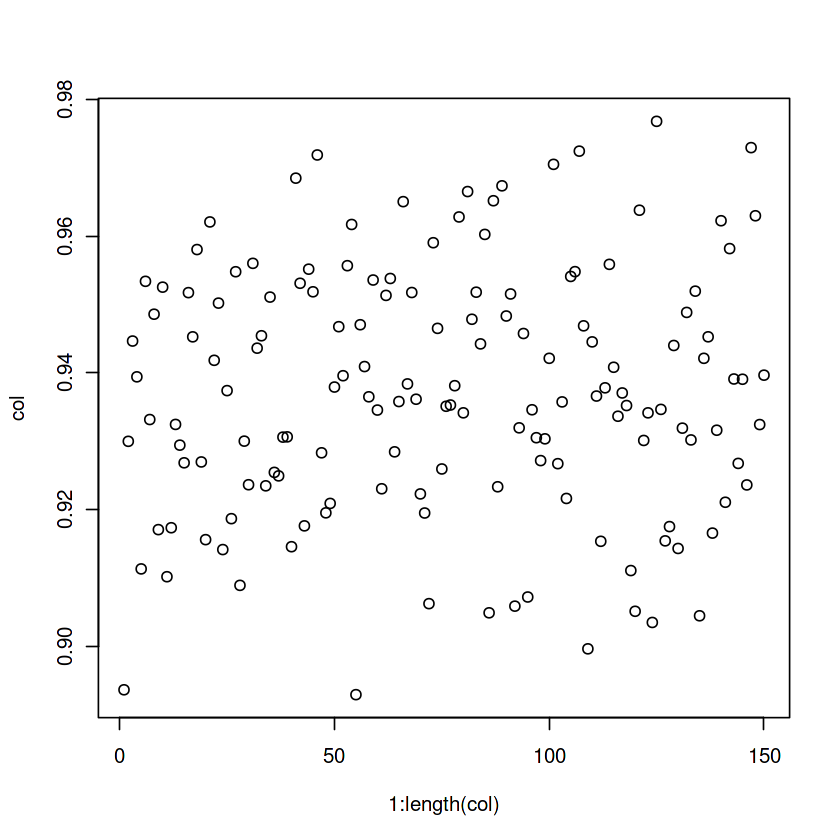

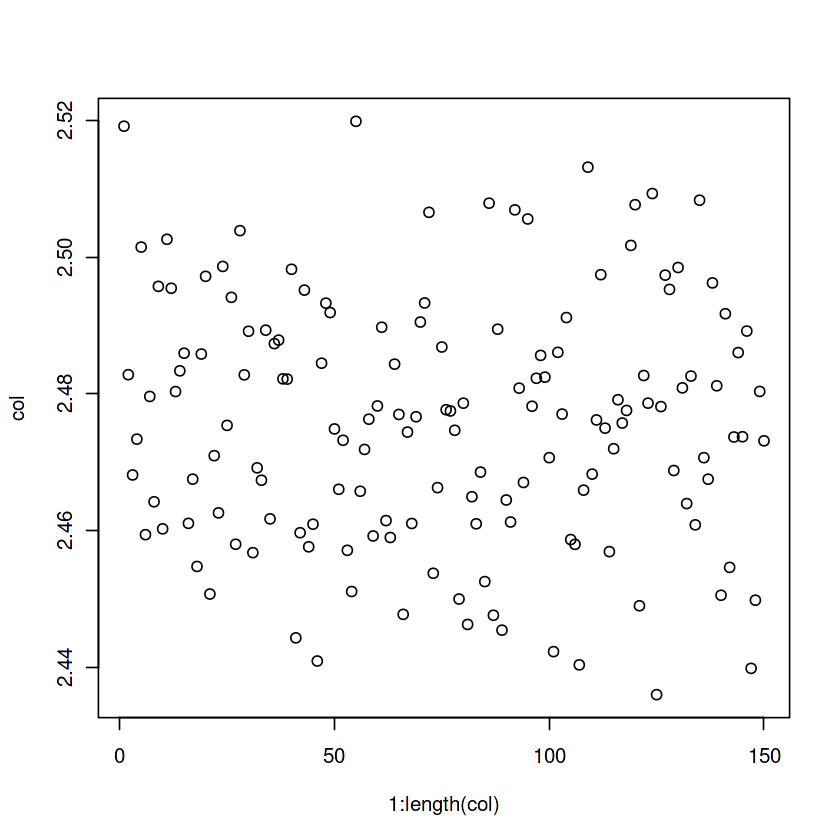

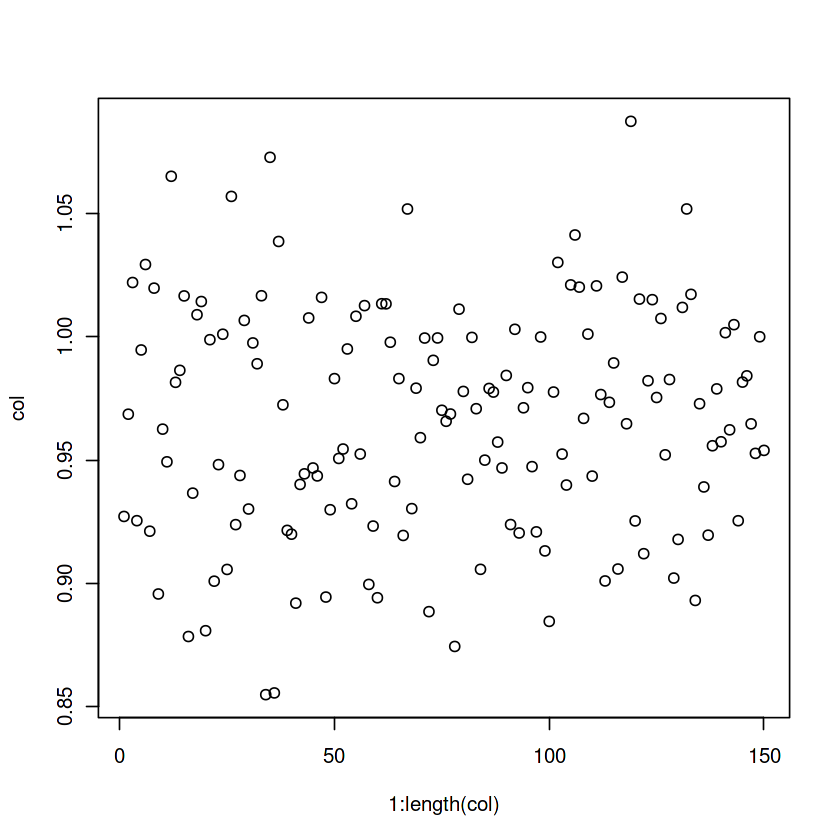

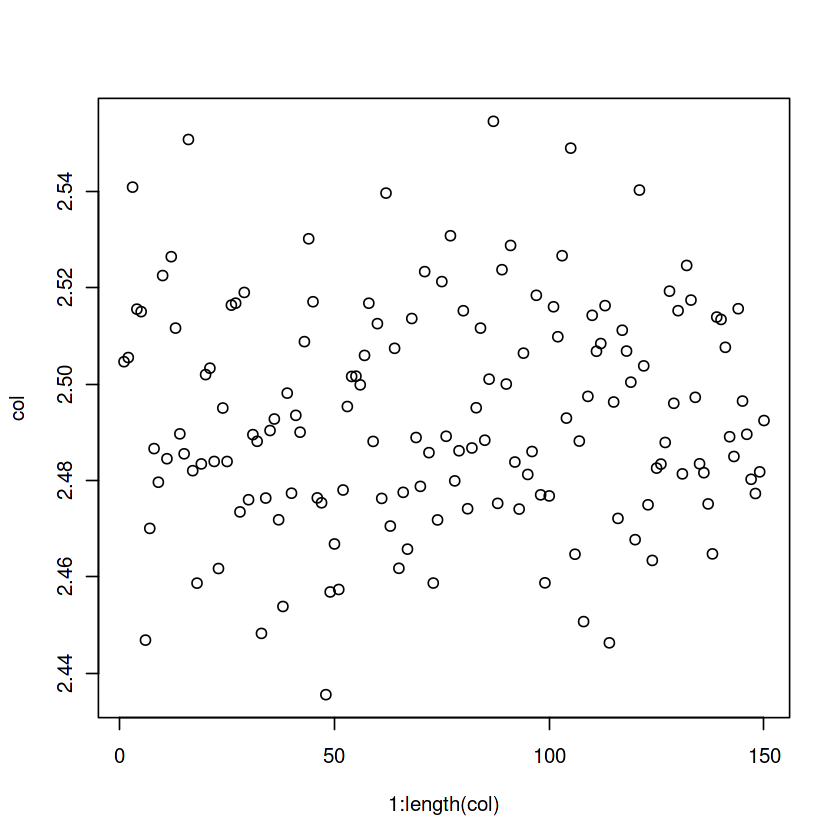

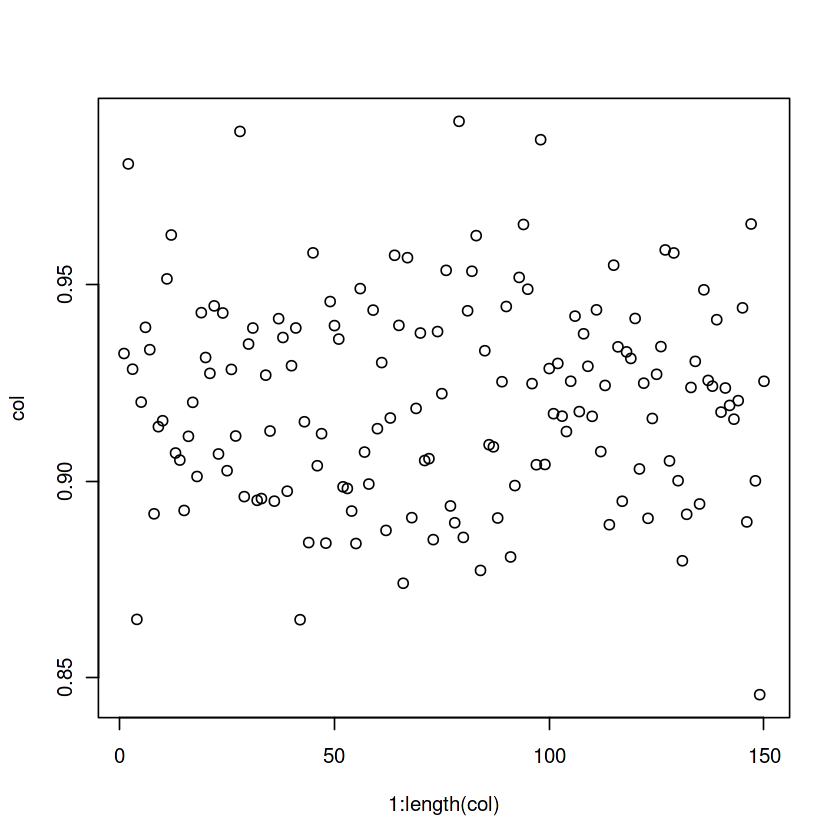

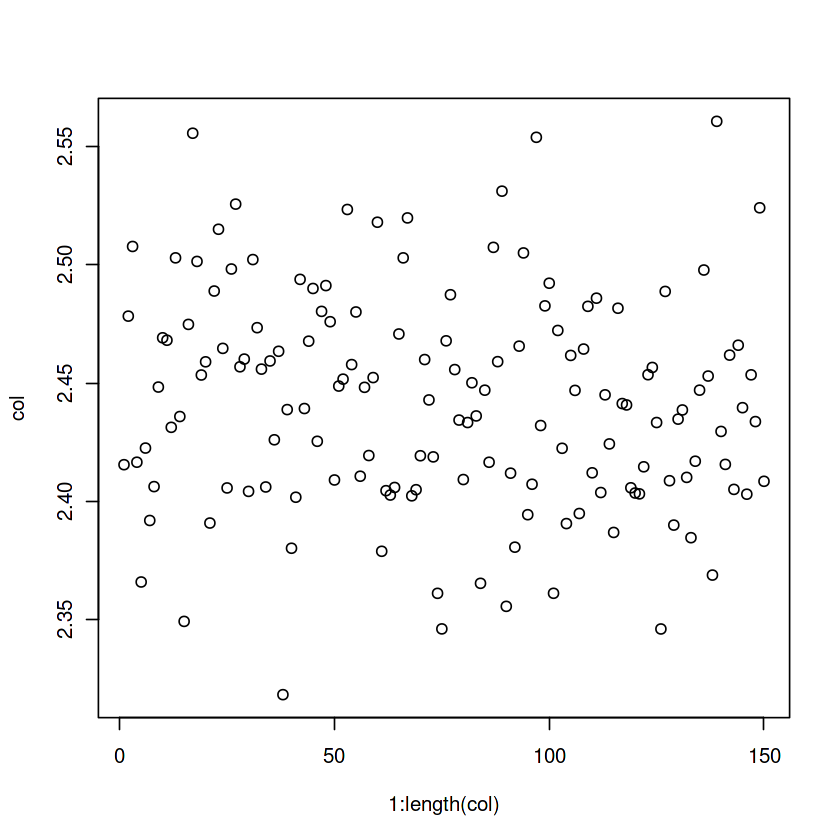

In [31]:
# Con estas gráficas visualizamos los valores que tomaron los límites en cada caso y dónde se acumularon
for(col in df){
    plot(1:length(col),col)
}

# Ejercicio 6

Al igual que en el Ejercicio 2, sólo evaluamo lo que se pide.

In [32]:
# Datos dados por el problema
mu = 5
set.seed(57)
X <- rnorm(100,mu,1)

# Estimador definido en el libro
hat_theta <- function(vec){
    theta <- exp(mean(vec))
    return(theta)
}

hat <- hat_theta(X)
print(hat)

[1] 153.9474


In [33]:
set.seed(57)
# Error estándar 
se_hat = sd( bootstrap(X,hat_theta,1000) )

# Repetí la semilla para que los valores que se obtienen en el bootstrap del intervalo 
# sean los mismos que en el bootstrap del error estándar.
set.seed(57)
# Intervalo normal
hat_interval = nb_interval(X,hat_theta,1000,0.05)

print(se_hat)
print(hat_interval)

[1] 17.6007
[1] 119.4507 188.4441


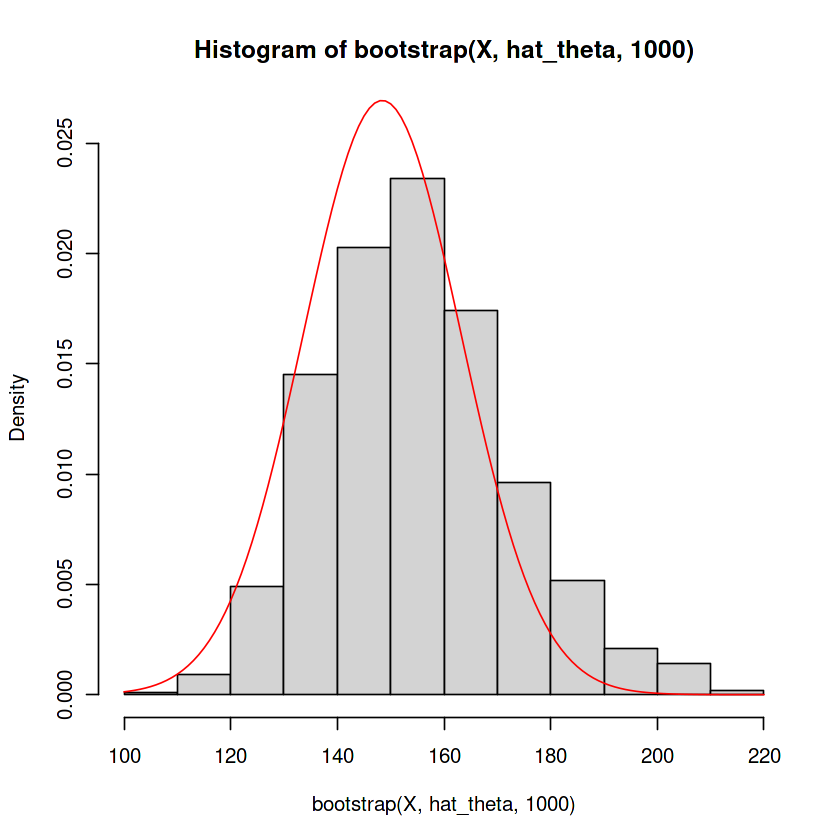

In [34]:
# De nuevo la semilla para que sigan siendo los mismos valores del bootstrap
set.seed(57)

x <- seq(100,220)
y <- dnorm(x, exp(5), sqrt((exp(1/100)-1)*(exp(10-1/100))) )

# Finalmente, la función de distribución verdadera de theta
# y el histograma de los datos estimados
hist( x = bootstrap(X,hat_theta,1000), freq=FALSE, ylim=c(0,0.026) )
lines( x=x, y, col="red" )